### Compares LGARTO (C) real examples against Hydrus
### Date: 23 October, 2024 (last updated)
### Peter La Follette

In [ ]:
#This notebook demonstrates LGARTO's ability to emulate Richards equation solver results 
#at the USDA SCAN site near Onward, MS. 


In [115]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
import importlib as imp
import copy
import pandas as pd
import datetime as dt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.dates as mdates

import pickle
import hydroeval

In [116]:
# C version
sim_case = 'outputs/Onward/data_variables.csv' 
c_path_vars = sim_case

outfile = "c-hydrus-comparison_Onward.png"
outfile_summpary_plot = "c-hydrus-comparison_Onward_summary.png"

save_outfile = True

In [117]:
num_steps = 8760
    
start = pd.Timestamp("2015-10-01 00:00:00")
end = pd.Timestamp("2016-09-30 00:00:00")
times = pd.date_range(start=start,end=end, periods=num_steps) #freq='min'
times_bmi = pd.date_range(start=start,end=end, periods=num_steps)

xfmt = mdates.DateFormatter('%Y/%m/%d')

In [118]:
data_c_vars = pd.read_csv(c_path_vars)
data_c_vars = data_c_vars[0:num_steps]
data_c_vars.head()

,Time,precipitation,potential_evapotranspiration,actual_evapotranspiration,surface_runoff,giuh_runoff,soil_storage,total_discharge,infiltration,percolation,groundwater_to_stream_recharge,mass_balance
0,2015-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.510355,0.0,0.0,0.000000e+00,0.0,0.0
1,2015-10-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.510355,0.0,0.0,-5.630700e-11,0.0,-0.0
2,2015-10-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.510355,0.0,0.0,5.218940e-10,0.0,0.0
3,2015-10-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.510355,0.0,0.0,-7.089620e-09,0.0,0.0
4,2015-10-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.510355,0.0,0.0,9.912210e-08,0.0,-0.0


In [119]:
m_to_mm = 1000


### Read Hydrus data

In [120]:

hyd_path = 'HYDRUS_outputs/Onward/T_Level.txt'

HYDRUS_output = pd.read_fwf(hyd_path,widths=[13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13])            
HYDRUS_datetime_vec = []
for i in range(0,len(HYDRUS_output['Time'])):
    current_dt = dt.datetime.strptime(data_c_vars['Time'][0],'%Y-%m-%d %H:%M:%S') + dt.timedelta(hours=HYDRUS_output['Time'][i])
    HYDRUS_datetime_vec.append(current_dt)
HYDRUS_output['HYDRUS_datetime_vec'] = HYDRUS_datetime_vec
HYDRUS_output = HYDRUS_output.set_index('HYDRUS_datetime_vec')

# HYDRUS_output = HYDRUS_output.resample('3600s').pad()

HYDRUS_output.head()


,Time,rTop,rRoot,vTop,vRoot,vBot,sum(rTop,) sum(rRoot,) sum(vTop,) sum(vRoot,...,hRoot,hBot,RunOff,sum(RunOff,) Volume,sum(Infil,) sum(Evap,) TLevel Cum(,WTrans) Snow,Layer
HYDRUS_datetime_vec,,,,,,,,,,,,,,,,,,,,,
2015-10-01 01:00:00,1.0,0.0,0.0,2.004300e-09,0.0,0.000012,0.0,0.0,2.004300e-09,0.0,...,-103.15,0.0,0.0,0.0,51.117,0.0,2.004300e-09,12 0.00,0.0,0.0
2015-10-01 02:00:00,2.0,0.0,0.0,2.004300e-09,0.0,0.000017,0.0,0.0,4.008700e-09,0.0,...,-103.15,0.0,0.0,0.0,51.117,0.0,4.008700e-09,24 0.00,0.0,0.0
2015-10-01 03:00:00,3.0,0.0,0.0,2.004300e-09,0.0,0.000016,0.0,0.0,6.013000e-09,0.0,...,-103.15,0.0,0.0,0.0,51.117,0.0,6.013000e-09,36 0.00,0.0,0.0
2015-10-01 04:00:00,4.0,0.0,0.0,2.004300e-09,0.0,0.000011,0.0,0.0,8.017300e-09,0.0,...,-103.15,0.0,0.0,0.0,51.117,0.0,8.017300e-09,48 0.00,0.0,0.0
2015-10-01 05:00:00,5.0,0.0,0.0,2.004300e-09,0.0,0.000009,0.0,0.0,1.002200e-08,0.0,...,-103.14,0.0,0.0,0.0,51.117,0.0,1.002200e-08,60 0.00,0.0,0.0


0       0.000000e+00
1      -5.630700e-09
2       4.655870e-08
3      -6.624033e-07
4       9.249807e-06
            ...     
8755   -8.627165e-01
8756   -8.627636e-01
8757   -8.628107e-01
8758   -8.628577e-01
8759   -8.629048e-01
Name: percolation, Length: 8760, dtype: float64


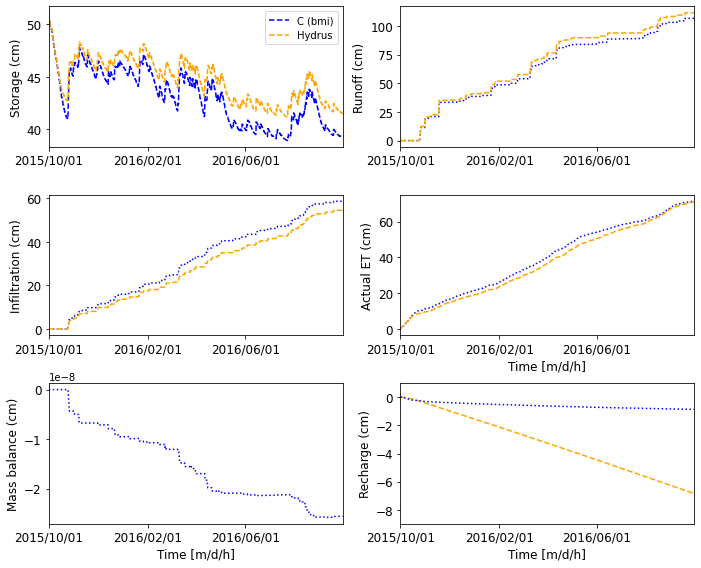

In [121]:
# end_step = 1000
# times_bmi = times_bmi[0:end_step]
# data_c_vars = data_c_vars [0:end_step]
# vars_hydrus = data_c_vars [0:end_step]
# HYDRUS_output = HYDRUS_output[0:end_step]





#%matplotlib qt
fig, axs = plt.subplots(3,2, figsize=(10,8), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

# vars_py = ['water_in_soil[mm]', 'runoff[mm/h]', 'actual_infil[mm/h]', 'actual_ET_per_step(mm)', 'mass_bal_error(mm)']
vars_bmi = ['soil_storage', 'surface_runoff', 'infiltration', 'actual_evapotranspiration', 'mass_balance', 'percolation']
vars_hydrus = [')     Volume', 'sum(RunOff', 'sum(Infil', ')   sum(vRoot', ')    sum(vBot']
m_to_mm = 1000
m_to_cm = 100
timestep = 300/3600
y_labels = ['Storage (cm)', 'Runoff (cm)', 'Infiltration (cm)', 'Actual ET (cm)', 'Mass balance (cm)', 'Recharge (cm)']

for i in range(len(y_labels)):
    if i == 0:
        if i == 0:
            axs[i].plot(times_bmi, data_c_vars[vars_bmi[i]]*m_to_cm,'b',linestyle='dashed',label='C (bmi)')
            axs[i].plot(HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus',color='orange')
        else:
            hyd = []
            for t,v1 in zip(HYDRUS_output['Time'], HYDRUS_output[vars_hydrus[0]]):
                if t % 5.0 == 0:
                    hyd.append(v1)
            hyd_c_diff = []

            #hydrus output data does not include t=0 data
            for v2, v3 in zip(np.array(hyd),np.array(data_c_vars[vars_bmi[0]]*m_to_cm)[1:]):
                hyd_c_diff.append(abs(v2-v3))

            axs[i].legend()
        
    elif (i < len(vars_hydrus)-1):
        if i == 1 or i == 2 or i ==3 :             
            axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'blue',linestyle='dotted',label='C (bmi)')  
            axs[i].plot(HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus',color='orange')
        if i==4:
            axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'blue',linestyle='dotted',label='C (bmi)')
            axs[4].axis(ymin=-1,ymax=1)
    elif (i==4):
        axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'blue',linestyle='dotted',label='C (bmi)')
        axs[5].plot(-1*HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus',color='orange')
        axs[5].axis(ymin=-9,ymax=1)
        print(np.cumsum(data_c_vars[vars_bmi[5]]*m_to_cm))
    else:
        axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'b',linestyle='dotted',label='C (bmi)')

            
    axs[i].set_ylabel(y_labels[i],fontsize=12)
    
    if i >2:
        axs[i].set_xlabel('Time [m/d/h]',fontsize=12)
    axs[i].tick_params(axis='x', labelsize=12,rotation=0)
    axs[i].tick_params(axis='y', labelsize=12,rotation=0)
    axs[i].xaxis.set_major_formatter(xfmt)
    axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    
    axs[i].set_xlim(times_bmi[0], times_bmi[-1])

##vertical line that helps to describe where we are 
# axs[0].vlines(x=times_bmi[2600],ymin=100*min(data_c_vars['soil_storage']),ymax=100*max(data_c_vars['soil_storage']),color='red')


axs[0].legend()
plt.tight_layout()

if (save_outfile):
    plt.savefig(outfile,dpi=400)


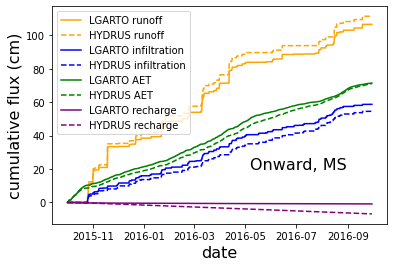

In [122]:

import matplotlib as mpl
plt.text(x=times_bmi[5250], y=20, s='Onward, MS', fontsize = 16)
mpl.rcParams['figure.facecolor'] = 'white'

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[1]]*m_to_cm),'b',label='C (bmi)',color='orange')
plt.plot(HYDRUS_output[vars_hydrus[1]],'k',linestyle='dashed',label='Hydrus',color='orange')

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[2]]*m_to_cm),'b',label='C (bmi)',color='blue')
plt.plot(HYDRUS_output[vars_hydrus[2]],'k',linestyle='dashed',label='Hydrus',color='blue')

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[3]]*m_to_cm),'b',label='C (bmi)',color='green')
plt.plot(HYDRUS_output[vars_hydrus[3]],'k',linestyle='dashed',label='Hydrus',color='green')

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[5]]*m_to_cm),'b',label='C (bmi)',color='purple')
plt.plot(-1*HYDRUS_output[vars_hydrus[4]],'k',linestyle='dashed',label='Hydrus',color='purple')

leg = plt.legend()#(handles=[runoff_line_HYDRUS,runoff_line_HYDRUS,runoff_line_HYDRUS,runoff_line_HYDRUS],labels=["LGARTO", "HYDRUS", "theta_e", "capillary head = -depth"])

mylabels = ['LGARTO runoff','HYDRUS runoff','LGARTO infiltration','HYDRUS infiltration','LGARTO AET','HYDRUS AET','LGARTO recharge','HYDRUS recharge']

plt.legend(labels=mylabels,ncol=1)

plt.ylabel("cumulative flux (cm)",fontsize=16)
plt.xlabel("date",fontsize=16)

if (save_outfile):
    plt.savefig(outfile_summpary_plot,dpi=400)

In [123]:
runoff_LGARTO = data_c_vars[vars_bmi[1]]*m_to_cm

# runoff_HYDRUS = HYDRUS_output['RunOff']

runoff_HYDRUS = [0.0]
for i in range(1,len(HYDRUS_output)):
#     if i!=1:
    runoff_HYDRUS.append(HYDRUS_output['sum(RunOff'][i] - HYDRUS_output['sum(RunOff'][i-1])

print("KGE in runoff: ")
print(hydroeval.kge(np.array(runoff_LGARTO), np.array(runoff_HYDRUS))[0][0])

print("NSE in runoff: ")
print(hydroeval.nse(np.array(runoff_LGARTO), np.array(runoff_HYDRUS)))

print("percent bias in runoff: ")
print(hydroeval.pbias(np.array(runoff_LGARTO), np.array(runoff_HYDRUS)))

print("RMSE in runoff (cm/h): ")
print(hydroeval.rmse(np.array(runoff_LGARTO), np.array(runoff_HYDRUS)))

print("cumulative runoff for LGARTO (cm): ")
print(np.sum(runoff_LGARTO))

print("cumulative runoff for HYDRUS (cm): ")
print(np.sum(runoff_HYDRUS))

print("difference (cm): ")
print(np.sum(runoff_HYDRUS) - np.sum(runoff_LGARTO))

KGE in runoff: 
0.9539447457561522
NSE in runoff: 
0.9941567429282971
percent bias in runoff: 
4.349424917255382
RMSE in runoff (cm/h): 
0.009556570870270491
cumulative runoff for LGARTO (cm): 
106.5930008722106
cumulative runoff for HYDRUS (cm): 
111.44
difference (cm): 
4.8469991277894025


In [124]:
np.sum(runoff_HYDRUS) == HYDRUS_output['sum(RunOff'][-1]

True

In [125]:
infil_LGARTO = data_c_vars[vars_bmi[2]]*m_to_cm
infil_HYDRUS = HYDRUS_output['sum(Infil']

infil_HYDRUS = np.array(infil_HYDRUS)
infil_HYDRUS_cumulative = HYDRUS_output['sum(Infil']

i=0
for item in infil_HYDRUS:
#     print(item)
    if (i==0):
        item = item
    else:
        item = item - infil_HYDRUS_cumulative[i-1]
    infil_HYDRUS[i] = item
    i = i + 1
    
        
print("KGE in infiltration: ")
print(hydroeval.kge(np.array(infil_LGARTO), np.array(infil_HYDRUS))[0][0])

print("NSE in infiltration: ")
print(hydroeval.nse(np.array(infil_LGARTO), np.array(infil_HYDRUS)))

print("percent bias in infiltration: ")
print(hydroeval.pbias(np.array(infil_LGARTO), np.array(infil_HYDRUS)))

print("RMSE in infiltration (cm/h): ")
print(hydroeval.rmse(np.array(infil_LGARTO), np.array(infil_HYDRUS)))

print("cumulative infiltration for LGARTO (cm): ")
print(np.sum(infil_LGARTO))

print("cumulative infiltration for HYDRUS (cm): ")
print(np.sum(infil_HYDRUS))

print("difference (cm): ")
print(np.sum(infil_HYDRUS) - np.sum(infil_LGARTO))

KGE in infiltration: 
0.8952291231784946
NSE in infiltration: 
0.9111511636042058
percent bias in infiltration: 
-7.655197360269437
RMSE in infiltration (cm/h): 
0.010159412613966204
cumulative infiltration for LGARTO (cm): 
58.73559912778939
cumulative infiltration for HYDRUS (cm): 
54.559
difference (cm): 
-4.176599127789395


In [126]:
np.sum(infil_HYDRUS) == HYDRUS_output['sum(Infil'][-1]

True

In [127]:
AET_LGARTO = data_c_vars[vars_bmi[3]]*m_to_cm
# AET_HYDRUS = HYDRUS_output['vRoot']

AET_HYDRUS = [0.0]
for i in range(1,len(HYDRUS_output)):
#     if i!=1:
    AET_HYDRUS.append(HYDRUS_output[')   sum(vRoot'][i] - HYDRUS_output[')   sum(vRoot'][i-1])

print("KGE in AET: ")
print(hydroeval.kge(np.array(AET_LGARTO), np.array(AET_HYDRUS))[0][0])

print("NSE in AET: ")
print(hydroeval.nse(np.array(AET_LGARTO), np.array(AET_HYDRUS)))

print("percent bias in AET: ")
print(hydroeval.pbias(np.array(AET_LGARTO), np.array(AET_HYDRUS)))

print("RMSE in AET (cm/h): ")
print(hydroeval.rmse(np.array(AET_LGARTO), np.array(AET_HYDRUS)))

print("cumulative AET for LGARTO (cm): ")
print(np.sum(AET_LGARTO))

print("cumulative AET for HYDRUS (cm): ")
print(np.sum(AET_HYDRUS))

print("difference (cm): ")
print(np.sum(AET_HYDRUS) - np.sum(AET_LGARTO))

KGE in AET: 
0.9447763633685895
NSE in AET: 
0.9660608354495056
percent bias in AET: 
-0.5544504386606773
RMSE in AET (cm/h): 
0.002434113972961608
cumulative AET for LGARTO (cm): 
71.42985941360699
cumulative AET for HYDRUS (cm): 
71.036
difference (cm): 
-0.3938594136069895


In [128]:
np.sum(AET_HYDRUS) == HYDRUS_output[')   sum(vRoot'][-1]

True

In [129]:
rch_LGARTO = data_c_vars[vars_bmi[5]]*m_to_cm
# rch_HYDRUS = -1*HYDRUS_output['vBot']

rch_HYDRUS = [0.0]
for i in range(1,len(HYDRUS_output)):
#     if i!=1:
    rch_HYDRUS.append(-1*(HYDRUS_output[')    sum(vBot'][i] - HYDRUS_output[')    sum(vBot'][i-1]))

print("KGE in recharge: ")
print(hydroeval.kge(np.array(rch_LGARTO), np.array(rch_HYDRUS))[0][0])

print("NSE in recharge: ")
print(hydroeval.nse(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("percent bias in recharge: ")
print(hydroeval.pbias(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("RMSE in recharge (cm/h): ")
print(hydroeval.rmse(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("cumulative recharge for LGARTO (cm): ")
print(np.sum(rch_LGARTO))

print("cumulative recharge for HYDRUS (cm): ")
print(np.sum(rch_HYDRUS))

print("difference (cm): ")
print(np.sum(rch_HYDRUS) - np.sum(rch_LGARTO))


KGE in recharge: 
-1.1540985916192326
NSE in recharge: 
-46.90955702820874
percent bias in recharge: 
87.40044998182036
RMSE in recharge (cm/h): 
0.0007545626113731439
cumulative recharge for LGARTO (cm): 
-0.862904818429
cumulative recharge for HYDRUS (cm): 
-6.8486955263
difference (cm): 
-5.985790707871001


In [130]:
abs(np.sum(rch_HYDRUS) - -1*HYDRUS_output[')    sum(vBot'][-1]) < 0.001

True

In [131]:
rch_HYDRUS=np.array(rch_HYDRUS)
rch_LGARTO=np.array(rch_LGARTO)

rch_HYDRUS_ind=np.array(rch_HYDRUS)
rch_LGARTO_ind=np.array(rch_LGARTO)

i = 0
for _ in rch_HYDRUS:
    if i>0:
        rch_HYDRUS[i] = np.sum(rch_HYDRUS_ind[0:i])
        rch_LGARTO[i] = np.sum(rch_LGARTO_ind[0:i])
    i=i+1

# plt.plot(rch_LGARTO)
# plt.plot(rch_HYDRUS)

print("KGE in cumulative recharge: ")
print(hydroeval.kge(np.array(rch_LGARTO), np.array(rch_HYDRUS))[0][0])

print("NSE in cumulative recharge: ")
print(hydroeval.nse(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("percent bias in cumulative recharge: ")
print(hydroeval.pbias(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("RMSE in cumulative recharge (cm): ")
print(hydroeval.rmse(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

KGE in cumulative recharge: 
-0.22004277880753786
NSE in cumulative recharge: 
-1.6106871325962406
percent bias in cumulative recharge: 
82.1302748066874
RMSE in cumulative recharge (cm): 
3.265040730478345
